<a href="https://colab.research.google.com/github/sathish19120/-Udacity-self-driving-car-dataset-with-realtime-object-detection-using-YOLO.-/blob/master/Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation (NMT)
We do build a German-English translation model. It is based on language translation pairs provided
here: http://www.manythings.org/anki/.
For German-English there are 195.847 language translation pairs available.

We implement a sequence to sequence (seq2seq) model, in particular an encoder-decoder model with attention (Bahdanau attention for the encoder). 

You will be able to input a German sentence, and return the English translation.

In addition, an attention plot is provided that shows which parts of the input sentence has the model's attention while translating.


In [0]:
#Import the latest version of Tensorflow (GPU processing)
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
#Load the data of language tranlation pairs.
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

--2019-08-09 19:42:01--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip.1’

deu-eng.zip.1       100%[===================>]   4.33M  15.5MB/s    in 0.3s    

2019-08-09 19:42:02 (15.5 MB/s) - ‘deu-eng.zip.1’ saved [4541707/4541707]

Archive:  deu-eng.zip
replace deu.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
#Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

#Prepare the data
#1. Creating a space between a word and the punctuation
#2. Clean the sentences by removing special characters.
#3. Add a start and end token to each sentence.

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    #1. Creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    #2. Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    #3. Adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = u"May I borrow this book?"
de_sentence = u"Kann ich das Buch ausleihen?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(de_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> kann ich das buch ausleihen ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, GERMAN]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [0]:
en, de = create_dataset('deu.txt', None)

#Show last language translation pair
print(en[-1])
print(de[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , dass seit erschaffung ebenderselben wohl noch 

In [0]:
#Pad each sentence to a maximum length
#Identfy maximum length
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
#Create a word index and reverse word index (dictionaries mapping from word → id and id → word)
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
#Create cleaned input, output pairs
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
#Limit the size of the dataset to experiment faster
num_examples = 60000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('deu.txt', num_examples)

#Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
#Creating training and test sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

#Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

48000 48000 12000 12000


In [0]:
#Show index to word mapping
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
#Show mapping for 1. training item
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
245 ----> morgen
24 ----> bin
5 ----> ich
178 ----> beschaftigt
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> i
32 ----> ll
37 ----> be
139 ----> busy
256 ----> tomorrow
3 ----> .
2 ----> <end>


In [0]:
#Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
#Show shape of dataset
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 12]))

In [0]:
#Define the encoder
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#Sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
#Define Bahdanau attention
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [0]:
#Define decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6821)


In [0]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
#Checkpoints (Object-based saving)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
#Define training steps
#1. Pass the input through the encoder. Returns encoder output and encoder hidden state.
#2. Pass to decoder: Encoder output, encoder hidden state and decoder input (start token).
#3. Decoder returns predictions and decoder hidden state.
#4. Decoder hidden state is passed back into the model; predictions are used to calculate loss.
#5. Use teacher forcing to decide the next input to the decoder.
#    Teacher forcing: Technique where the target word is passed as the next input to the decoder.
#6. Final step: Calculate the gradients and apply it to the optimizer and backpropagate.
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
#Execute training
EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6440
Epoch 1 Batch 100 Loss 2.2668
Epoch 1 Batch 200 Loss 1.8954
Epoch 1 Batch 300 Loss 1.9263
Epoch 1 Batch 400 Loss 1.6391
Epoch 1 Batch 500 Loss 1.5843
Epoch 1 Batch 600 Loss 1.5569
Epoch 1 Batch 700 Loss 1.4727
Epoch 1 Loss 1.7715
Time taken for 1 epoch 129.7197711467743 sec

Epoch 2 Batch 0 Loss 1.3412
Epoch 2 Batch 100 Loss 1.3865
Epoch 2 Batch 200 Loss 1.0574
Epoch 2 Batch 300 Loss 1.2304
Epoch 2 Batch 400 Loss 1.0397
Epoch 2 Batch 500 Loss 0.9678
Epoch 2 Batch 600 Loss 1.0216
Epoch 2 Batch 700 Loss 0.8918
Epoch 2 Loss 1.0253
Time taken for 1 epoch 103.01406073570251 sec

Epoch 3 Batch 0 Loss 0.8379
Epoch 3 Batch 100 Loss 0.8698
Epoch 3 Batch 200 Loss 0.6390
Epoch 3 Batch 300 Loss 0.8008
Epoch 3 Batch 400 Loss 0.6181
Epoch 3 Batch 500 Loss 0.6016
Epoch 3 Batch 600 Loss 0.6544
Epoch 3 Batch 700 Loss 0.5534
Epoch 3 Loss 0.6149
Time taken for 1 epoch 102.20961785316467 sec

Epoch 4 Batch 0 Loss 0.5317
Epoch 4 Batch 100 Loss 0.5519
Epoch 4 Batch 200 Loss 0.396

In [0]:
#Define evalation (similar to the training loop, except no teacher forcing)
#1. Decoder input (at each time step): Previous predictions along with hidden state and encoder output.
#2. Stop predicting when the model predicts the end token.
#3. Store the attention weights for every time step.
#Note: The encoder output is calculated only once for one input.
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
#Define function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
#Define translation function
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
#Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> wieviel uhr ist es ? <end>
Predicted translation: what time is it ? <end> 


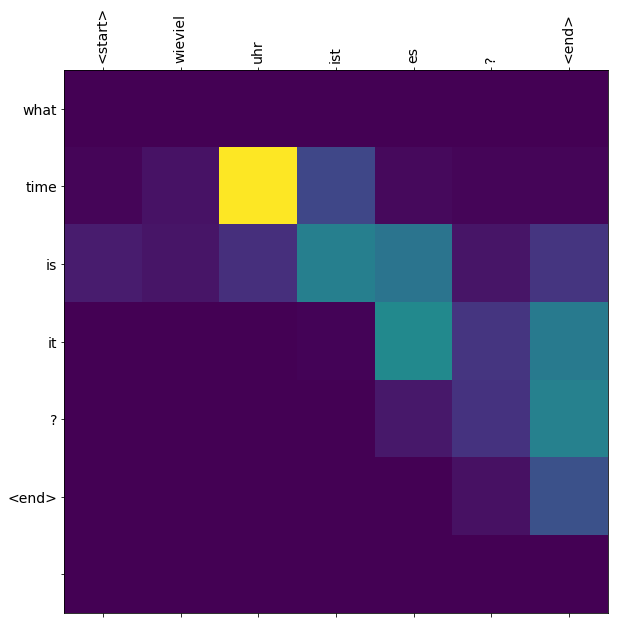

In [0]:
translate(u'Wieviel Uhr ist es?')

Input: <start> eine lange reise hort nicht am ziel auf . <end>
Predicted translation: it s all start at all night . <end> 


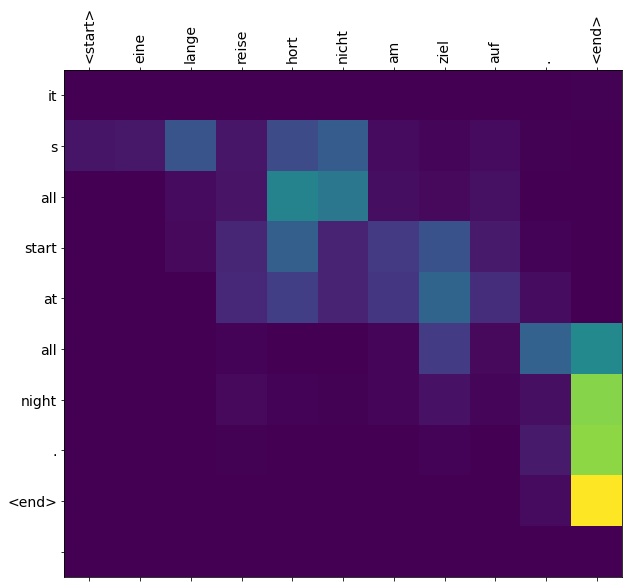

In [0]:
translate(u'Eine lange Reise hört nicht am Ziel auf.')

Input: <start> einmal im jahr solltest du einen ort besuchen , an dem du noch nie warst . <end>
Predicted translation: enjoy your year . <end> 


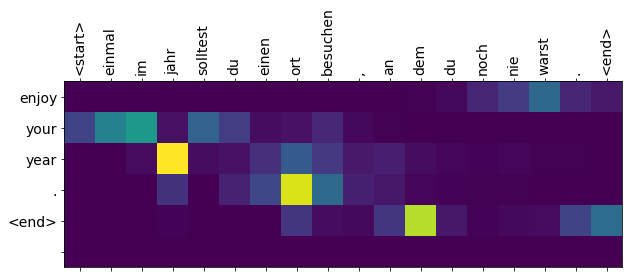

In [0]:
translate(u'Einmal im Jahr solltest du einen Ort besuchen, an dem du noch nie warst.')